In [35]:
import time
import random
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import numpy as np
import scipy
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import RANSACRegressor, LinearRegression, TheilSenRegressor
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_absolute_error, median_absolute_error, r2_score
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso, ElasticNet, BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
import seaborn
from IPython.display import Image
import copy

# Feature Exploration

In [32]:
data = pd.read_excel('Concrete_Data.xls')
print(len(data))
data.head()

1030


,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.270
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.053
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296


In [33]:
# rename columns
data.columns = ['cement_component', 'furnace_slag', 'fly_ash', 'water_component', 'superplasticizer',
               'coarse_aggregate', 'fine_aggregate', 'age', 'concrete_strength']
data.head()

,cement_component,furnace_slag,fly_ash,water_component,superplasticizer,coarse_aggregate,fine_aggregate,age,concrete_strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.270
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.053
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296


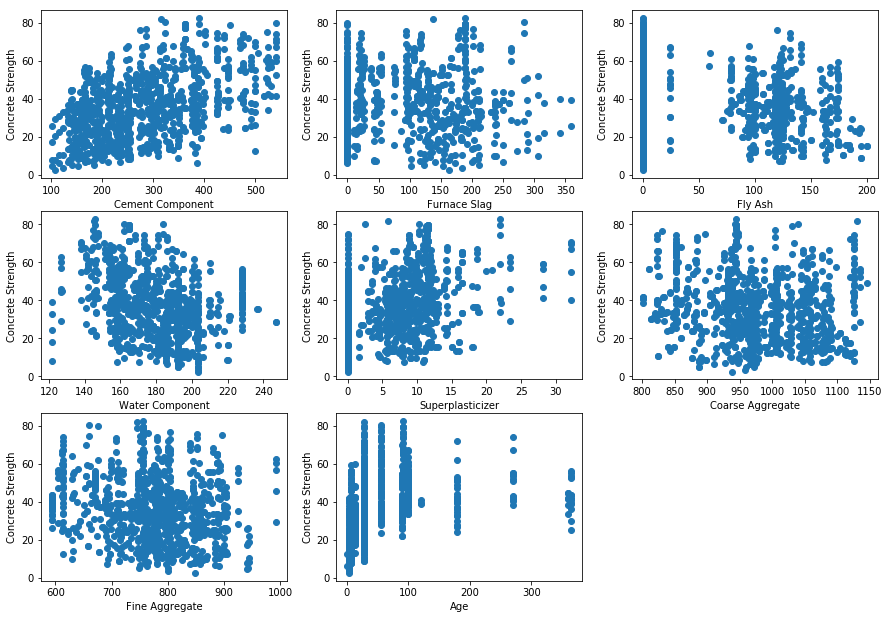

In [34]:
plt.figure(figsize=(15,10.5))
plot_count = 1
for feature in list(data.columns)[:-1]:
    plt.subplot(3,3,plot_count)
    plt.scatter(data[feature], data['concrete_strength'])
    plt.xlabel(feature.replace('_', ' ').title())
    plt.ylabel('Concrete Strength')
    plot_count += 1
    
plt.show()

In [36]:
# calculating the Pair-wise pearson correlations
data_1 = copy.deepcopy(data)
pd.set_option('display.width', 100)
pd.set_option('precision', 3)
data_ = data_1[(data_1.T != 0).any()]
correlations = data_.corr(method='pearson')
print(correlations)

                   cement_component  furnace_slag  fly_ash  water_component  superplasticizer  \
cement_component              1.000        -0.275   -0.397           -0.082             0.093   
furnace_slag                 -0.275         1.000   -0.324            0.107             0.043   
fly_ash                      -0.397        -0.324    1.000           -0.257             0.377   
water_component              -0.082         0.107   -0.257            1.000            -0.657   
superplasticizer              0.093         0.043    0.377           -0.657             1.000   
coarse_aggregate             -0.109        -0.284   -0.010           -0.182            -0.266   
fine_aggregate               -0.223        -0.282    0.079           -0.451             0.223   
age                           0.082        -0.044   -0.154            0.278            -0.193   
concrete_strength             0.498         0.135   -0.106           -0.290             0.366   

                   coarse_agg

C:\Users\MyPC\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


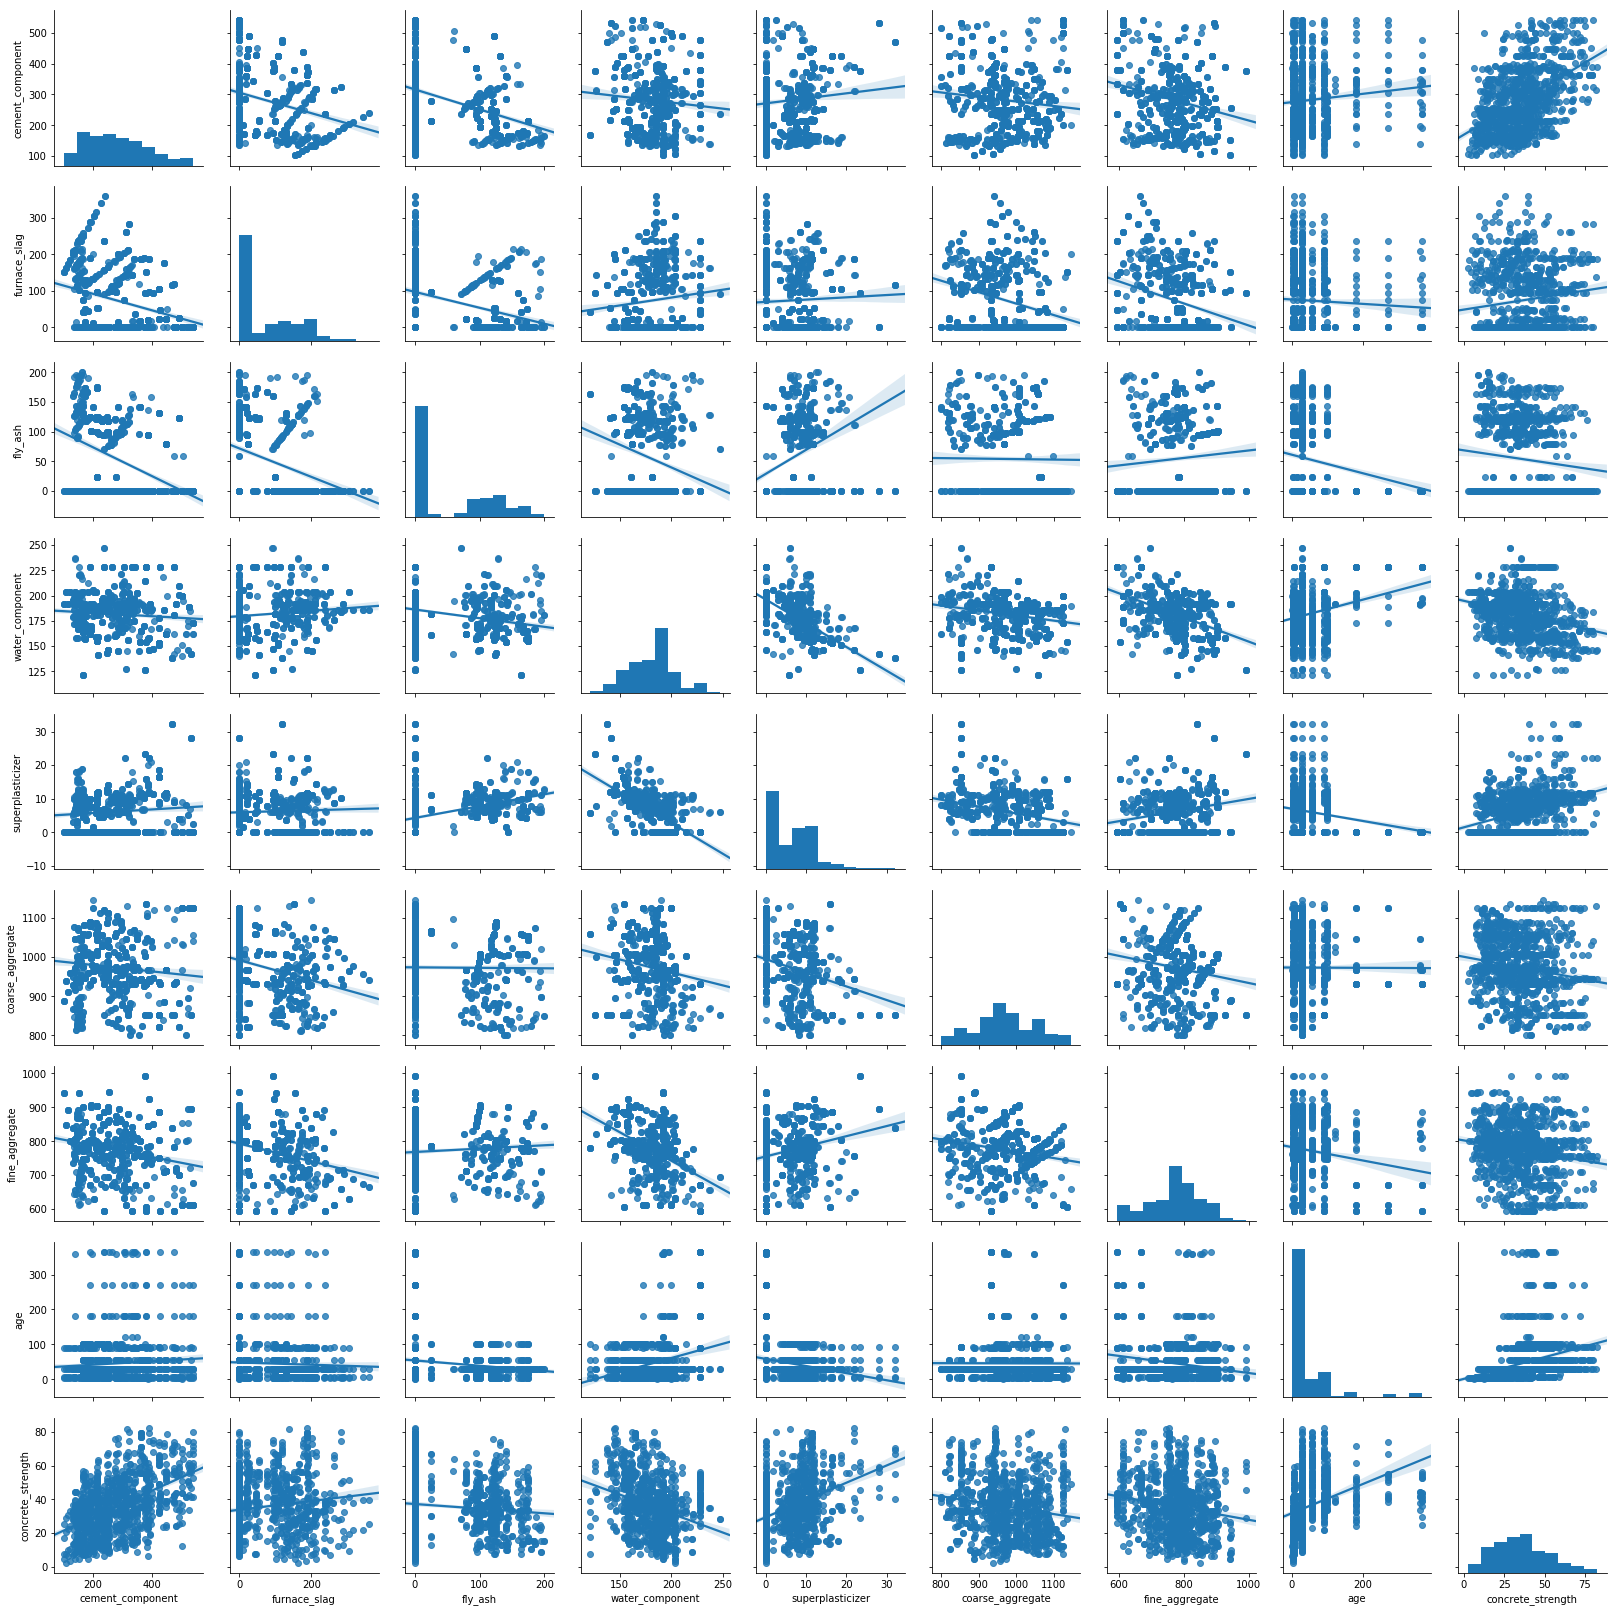

In [37]:
# calculate pair plot between all features
data_ = data_1[(data_1.T != 0).any()]
seaborn.pairplot(data_, vars=data.columns, kind='reg')
plt.show()

# Training Data

In [38]:
def split_train_test(data, feature, train_index=0.7):
    train, test = train_test_split(data, test_size=1-train_index)
    
    if type(feature) == list:
        x_train = train[feature].as_matrix()
        y_train = train['concrete_strength'].as_matrix()
        
        x_test = test[feature].as_matrix()
        y_test = test['concrete_strength'].as_matrix()
        
    else:
        x_train = [[x] for x in list(train[feature])]
        y_train = [[x] for x in list(train['concrete_strength'])]
        
        x_test = [[x] for x in list(test[feature])]
        y_test = [[x] for x in list(test['concrete_strength'])]
        
    return x_train, y_train, x_test, y_test

# Linear Regression

cement_component 0.2854642844403197
fly_ash 0.04312919010886085
water_component 0.026552529073765485
superplasticizer 0.09826891495194046
coarse_aggregate -0.0011307157775874987


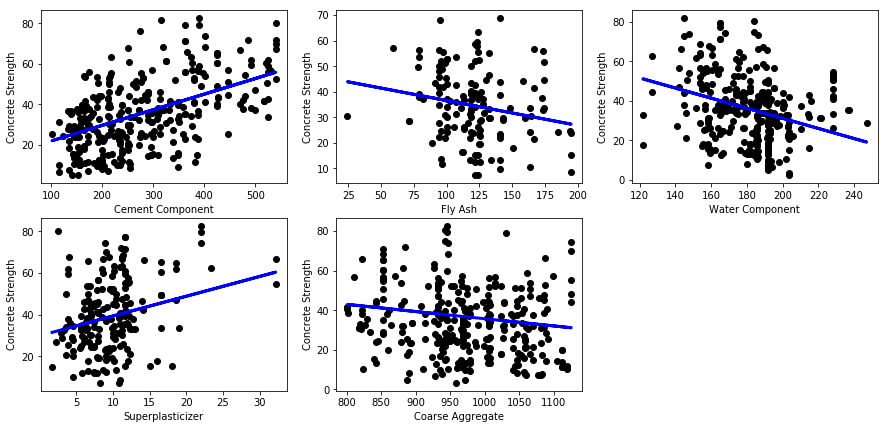

In [39]:
plt.figure(figsize=(15,7))
plot_count = 1
linear_data = copy.deepcopy(data)
for feature in ['cement_component', 'fly_ash', 'water_component', 'superplasticizer', 'coarse_aggregate']:
    data_tr = linear_data[['concrete_strength', feature]]
    data_tr = data_tr[(data_tr.T != 0).all()]
    
    x_train, y_train, x_test, y_test = split_train_test(data_tr, feature)
    
    # Create Linear Regression Object
    reg = LinearRegression()

    # Train Model
    reg.fit(x_train, y_train)
    y_pred = reg.predict(x_test)

    # Plot Outputs
    plt.subplot(2,3,plot_count)

    plt.scatter(x_test, y_test, color='black')
    plt.plot(x_test, y_pred, color='blue', linewidth=3)
    plt.xlabel(feature.replace('_', ' ').title())
    plt.ylabel('Concrete Strength')
    print(feature, r2_score(y_test, y_pred))

    plot_count+=1

plt.show()

# Multiple Linear Regression

Features: ['cement_component', 'fly_ash', 'water_component', 'superplasticizer', 'coarse_aggregate']
R2: 0.12376980844329044
Intercept: 86.01017523734164
Coefficients: [ 0.04533127 -0.03203665 -0.18295744  0.2524851  -0.02716495]


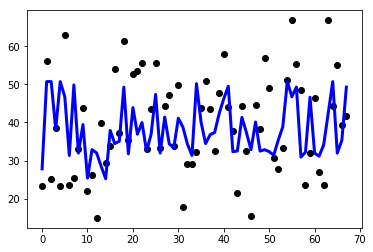

In [42]:
features = ['cement_component', 'fly_ash', 'water_component', 'superplasticizer', 'coarse_aggregate']
m_linear_data = copy.deepcopy(data)
data_tr = m_linear_data
data_tr = data_tr[(data_tr.T != 0).all()]

x_train, y_train, x_test, y_test = split_train_test(data_tr, features)

# Create Linear Regression
reg = LinearRegression()

# train the model using the training sets
reg.fit(x_train, y_train)
y_pred = reg.predict(x_test)

plt.scatter(range(len(y_test)), y_test, color='black')
plt.plot(y_pred, color='blue', linewidth=3)

print('Features: {}'.format(features))
print('R2: {}'.format(r2_score(y_test, y_pred)))
print('Intercept: {}'.format(reg.intercept_))
print('Coefficients: {}'.format(reg.coef_))